In [ ]:
# Authors:
# Freese, Julius <jufr23ac@student.cbs.dk>
# Haunberger, Vincent <viha23al@student.cbs.dk>
# Schröder, Fynn <fysc23ab@student.cbs.dk>

In [ ]:
"""This notebook contains all code related to data operations, including load,
preprocessing, feature engineering and data splitting. This way, we are able to build 
models that can be compared to each other.

Sections:
(1) Data Load & Cleaning
(2) Feature Engineering
(3) Dataset Creation
"""

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

## (1) Data Load & Cleaning

In [ ]:
-- Query to clean and load events data from BigQuery

SELECT
  DISTINCT CAST(EventTimestamp AS TIMESTAMP) AS EventTimestamp,
  UserId, 
  ContentItemId,
  EngagementTimeMsec,
  PageTitle,
  PageLocation,
  PageReferrer,
  City,
  Region,
  Country,
  DeviceLang,
  DeviceOS,

FROM (
  SELECT
    event_name,
    CAST(FORMAT_TIMESTAMP('%F %R:%E*S', TIMESTAMP_MICROS(event_timestamp), 'UTC') AS timestamp) AS EventTimestamp,

    -- Unnest google analytics data format
    (SELECT
      IFNULL(value.string_value,
      IFNULL(CAST(value.int_value AS string),
      IFNULL(CAST(value.float_value AS string),
      IFNULL(CAST(value.double_value AS string), ''))))
    FROM  UNNEST(event_params)  WHERE  KEY = 'label') AS ContentItemId,

    (SELECT
      IFNULL(value.string_value,
      IFNULL(CAST(value.int_value AS string),
      IFNULL(CAST(value.float_value AS string),
      IFNULL(CAST(value.double_value AS string), ''))))
    FROM  UNNEST(event_params)  WHERE  KEY = 'engagement_time_msec') AS EngagementTimeMsec,

    (SELECT
      IFNULL(value.string_value,
      IFNULL(CAST(value.int_value AS string),
      IFNULL(CAST(value.float_value AS string),
      IFNULL(CAST(value.double_value AS string), ''))))
    FROM  UNNEST(event_params)  WHERE  KEY = 'page_title') AS PageTitle,

    (SELECT
      IFNULL(value.string_value,
      IFNULL(CAST(value.int_value AS string),
      IFNULL(CAST(value.float_value AS string),
      IFNULL(CAST(value.double_value AS string), ''))))
    FROM  UNNEST(event_params)  WHERE  KEY = 'page_location') AS PageLocation,

    (SELECT
      IFNULL(value.string_value,
      IFNULL(CAST(value.int_value AS string),
      IFNULL(CAST(value.float_value AS string),
      IFNULL(CAST(value.double_value AS string), ''))))
    FROM  UNNEST(event_params)  WHERE  KEY = 'page_referrer') AS PageReferrer,

    TO_BASE64(hashed_user_pseudo_id) AS UserId,
    device.operating_system AS DeviceOS,
    device.language AS DeviceLang,
    geo.city AS City,
    geo.country AS Country,
    geo.region AS Region,
    user_first_touch_timestamp AS UserFirstTouchTimestamp

  FROM
    `events_hashed` 
  -- filter for only page_click_op events; this reduces the data volume drastically
  WHERE
  event_name IN ('page_click_op')
  )
WHERE  
UserId IS NOT NULL

In [3]:
df_events = pd.read_csv('data/raw/events_data.csv')
df_events['EventTimestamp'] = pd.to_datetime(df_events['EventTimestamp'], format="mixed")
df_events['EventTimestamp'] = df_events['EventTimestamp'].dt.tz_localize(None)
print(df_events.shape)
df_events.head(2)

(2228252, 12)


,EventTimestamp,UserId,ContentItemId,EngagementTimeMsec,PageTitle,PageLocation,PageReferrer,City,Region,Country,DeviceLang,DeviceOS
0,2024-02-01 21:51:43.622737,w18Lmo4tRREEWjZgicQxzHxzmHLobNuIyX6QxLicnAw=,{E8700A38-430F-4B14-9087-CDA21A4F2AB7},80922.0,Få 3 tips til gode motionsvaner af læge Bente ...,https://www.aeldresagen.dk/viden-og-raadgivnin...,NaN,NaN,Castile-La Mancha,Spain,da-dk,iOS
1,2024-04-30 18:55:49.884169,zGndJ7Rj6dqxvY43P5eVfadVKyJLImcZZ/4eu9wYl1g=,{155D6723-F111-4E8B-928C-E8CA4BB539E4},65890.0,Sådan spotter du telefonopkald fra svindlere,https://www.aeldresagen.dk/viden-og-raadgivnin...,NaN,Stockholm,Stockholm County,Sweden,da-dk,Macintosh


In [4]:
df_items = pd.read_csv('data/raw/content_data.csv')
print(df_items.shape)
df_items.head(2)

(7092, 14)


,ItemId,ItemName,TemplateId,TemplateName,PageUrl,Category,Heading,Teaser,Subject,Text,Image,Created,Expires,Exported
0,{F5E9BF4C-B698-45E3-9E08-59AB528AA0C6},arbejdsliv,{4EDF5E39-033F-4AA7-86A0-20414CA0B49B},TopicPage,https://www.aeldresagen.dk/viden-og-raadgivnin...,1,"Få gode råd om jobskifte, senkarriere og jobsø...","Nogle fortsætter mange år i samme arbejde, men...",Arbejdsliv,<p>\nArbejde er for mange en stor del af deres...,https://billeder.aeldresagen.dk/cdn/xZ98Dm/5MC...,2019-03-18 19:04:44,NaN,2024-04-24 04:52:47
1,{E5D5009B-0E45-4821-BC11-1AC9BBEC1736},arv-og-testamente,{4EDF5E39-033F-4AA7-86A0-20414CA0B49B},TopicPage,https://www.aeldresagen.dk/viden-og-raadgivnin...,1,Hvordan skal din arv fordeles?,Det kan være svært at forholde sig til livets ...,Arv & testamente,"<p>Der er flere grunde til, at det er en god i...",https://billeder.aeldresagen.dk/cdn/xZbs0R/5MC...,2019-03-18 19:04:44,NaN,2024-04-24 04:52:47


In [5]:
# Create mappings for user and item ids - this is necessary to use the ids in the models
df_events['uid'] = pd.Categorical(df_events['UserId']).codes
df_events['cid'] = pd.Categorical(df_events['ContentItemId']).codes

uid_mapping = df_events[['uid', 'UserId']].drop_duplicates().set_index('UserId')['uid']
cid_mapping = df_events[['cid', 'ContentItemId']].drop_duplicates().set_index('ContentItemId')['cid']

In [18]:
# save mappings
#uid_mapping.to_csv('data/mappings/uid_mapping.csv')
#cid_mapping.to_csv('data/mappings/cid_mapping.csv')

## (2) Feature Engineering

#### Items

In [6]:
# Items Dataframe

df_items_fe = df_items.copy()

# merge items with item mappings by ContentItemId to get the cid (the index)
df_items_fe = df_items_fe.merge(cid_mapping, left_on='ItemId', right_on='ContentItemId')
df_items_fe.drop(columns=[ "TemplateId"], inplace=True) # 'ItemId',
df_items_fe.set_index('cid', inplace=True)
df_items_fe = df_items_fe.copy()
print(df_items_fe.shape)
df_items_fe.head(2)

(6648, 13)


,ItemId,ItemName,TemplateName,PageUrl,Category,Heading,Teaser,Subject,Text,Image,Created,Expires,Exported
cid,,,,,,,,,,,,,
6381,{F5E9BF4C-B698-45E3-9E08-59AB528AA0C6},arbejdsliv,TopicPage,https://www.aeldresagen.dk/viden-og-raadgivnin...,1,"Få gode råd om jobskifte, senkarriere og jobsø...","Nogle fortsætter mange år i samme arbejde, men...",Arbejdsliv,<p>\nArbejde er for mange en stor del af deres...,https://billeder.aeldresagen.dk/cdn/xZ98Dm/5MC...,2019-03-18 19:04:44,NaN,2024-04-24 04:52:47
5962,{E5D5009B-0E45-4821-BC11-1AC9BBEC1736},arv-og-testamente,TopicPage,https://www.aeldresagen.dk/viden-og-raadgivnin...,1,Hvordan skal din arv fordeles?,Det kan være svært at forholde sig til livets ...,Arv & testamente,"<p>Der er flere grunde til, at det er en god i...",https://billeder.aeldresagen.dk/cdn/xZbs0R/5MC...,2019-03-18 19:04:44,NaN,2024-04-24 04:52:47


#### Events (Interactions)

In [7]:
# Interactions Data Frame
df_events_fe = df_events.copy()

# merge events with user mappings by UserId to get the uid (the index)
df_events_fe = df_events_fe.merge(uid_mapping, left_on='UserId', right_on='UserId')

# merge events with item mappings by ContentItemId to get the cid (the index)
df_events_fe = df_events_fe.merge(cid_mapping, left_on='ContentItemId', right_on='ContentItemId')

# rename uid_x and uid_y to uid and cid
df_events_fe.rename(columns={'uid_x': 'uid', 'cid_x': 'cid'}, inplace=True)
df_events_fe.drop(columns=['uid_y', 'cid_y'], inplace=True)

# only take the first part after www from page referrer domain
df_events_fe['PageReferrerDomain'] = df_events_fe['PageReferrer'].str.extract(r'(?P<domain>www\.[^.]+)').fillna('unknown')

# only take the top 10 most frequent domains, the rest are grouped into 'other'
# extremly long tail of domains
top_domains = df_events_fe['PageReferrerDomain'].value_counts().head(10).index
df_events_fe.loc[~df_events_fe['PageReferrerDomain'].isin(top_domains), 'PageReferrerDomain'] = 'other'

# device lang: take the first part of the language code
df_events_fe['DeviceLang'] = df_events_fe['DeviceLang'].str.extract(r'(?P<lang>[^-]+)').fillna('unknown')

# only take the top 10 most frequent languages, the rest are grouped into 'other'
top_langs = df_events_fe['DeviceLang'].value_counts().head(10).index
df_events_fe.loc[~df_events_fe['DeviceLang'].isin(top_langs), 'DeviceLang'] = 'other'

# take only the top 30 countries, the rest are grouped into 'other'
top_countries = df_events_fe['Country'].value_counts().head(30).index
df_events_fe.loc[~df_events_fe['Country'].isin(top_countries), 'Country'] = 'other'

# take only the top 30 regions, the rest are grouped into 'other'
top_regions = df_events_fe['Region'].value_counts().head(30).index
df_events_fe.loc[~df_events_fe['Region'].isin(top_regions), 'Region'] = 'other'

# Create Date column that is only the date part of the EventTimestamp
df_events_fe['Date'] = df_events_fe['EventTimestamp'].dt.date

# drop columns
cols_to_drop = ["UserId", "ContentItemId", "PageTitle", "PageLocation", "PageReferrer", "City"]
df_events_fe.drop(columns=cols_to_drop, inplace=True)

reorder = ["uid", "cid", "EventTimestamp", "Date", "EngagementTimeMsec", "Region", "Country", "DeviceLang", "DeviceOS", "PageReferrerDomain"]
df_events_fe = df_events_fe[reorder]

print(df_events_fe.shape)
df_events_fe.head(2)

(2228252, 10)


,uid,cid,EventTimestamp,Date,EngagementTimeMsec,Region,Country,DeviceLang,DeviceOS,PageReferrerDomain
0,503553,6032,2024-02-01 21:51:43.622737,2024-02-01,80922.0,Castile-La Mancha,Spain,da,iOS,unknown
1,460787,6032,2024-01-31 12:57:08.119090,2024-01-31,1927.0,Region of Southern Denmark,Denmark,da,Windows,unknown


In [39]:
# group by uid, cid, date and sum the engagement time and count the events per date not timestamp
interactions = df_events_fe.groupby(['uid', 'cid', 'Date']).agg({'EngagementTimeMsec': 'sum'}).reset_index()
interactions.columns = ['uid', 'cid', 'Date', 'engagement_time']
interactions['click'] = 1
print(f"initial shape: {interactions.shape}")

# apply log to engagement time
interactions['engagement_time'] = np.log1p(interactions['engagement_time'])

# Filtering for users that visited 3 different pages
interactions = interactions.groupby('uid').filter(lambda x: len(x) >= 2)
interactions = interactions.groupby('cid').filter(lambda x: len(x) >= 2)
print("shape after filtering:", interactions.shape)

# Normalize the engagement time and event count
# Initialize the scaler, setting the feature range from 1 to 5
scaler = MinMaxScaler(feature_range=(0, 1))
interactions['engagement_time'] = scaler.fit_transform(interactions[['engagement_time']])

interactions['eid'] = interactions['uid'].astype(str) + "_" + interactions['cid'].astype(str) + "_" + interactions['Date'].astype(str)
interactions.set_index('eid', inplace=True)
print(interactions.shape)
interactions.head(2)

initial shape: (1081697, 5)
shape after filtering: (753299, 5)
(753299, 5)


,uid,cid,Date,engagement_time,click
eid,,,,,
5_6321_2024-01-30,5,6321,2024-01-30,0.762305,1
5_6321_2024-02-05,5,6321,2024-02-05,0.559014,1


<Axes: ylabel='Frequency'>

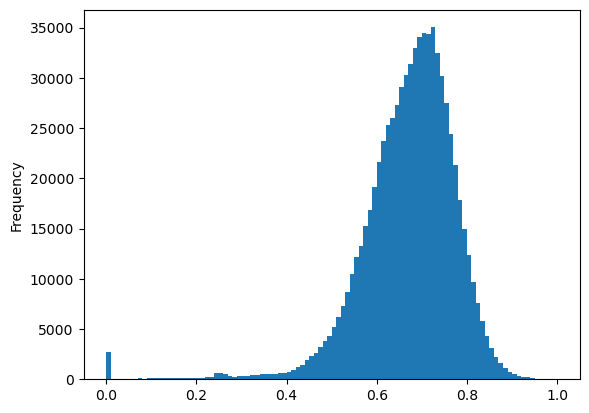

In [40]:
# plot distribution of engagement time
interactions['engagement_time'].plot.hist(bins=100)

#### Users

In [32]:
# Unique Users Dataframe
users = df_events_fe.copy()

# concat uid, cid and date to eid
users['eid'] = users['uid'].astype(str) + "_" + users['cid'].astype(str) + "_" + users['Date'].astype(str)
users = users.groupby('eid').agg({
        'uid': 'first',
        'cid': 'first',
        'Date': 'first',
        'EngagementTimeMsec': 'sum',
        'Region': 'first',
        'Country': 'first',
        'DeviceLang': 'first',
        'DeviceOS': 'first',
        'PageReferrerDomain': 'first'
    })

users = users.groupby('uid').filter(lambda x: len(x) >= 2)
users = users.groupby('cid').filter(lambda x: len(x) >= 2)

# log transform the engagemenet time, since it is highly skewed towards 0. This could 
# interfere with negative (0) samples later.
users['EngagementTimeMsec'] = np.log1p(users['EngagementTimeMsec'])

scaler = MinMaxScaler(feature_range=(0, 1))
users['EngagementTimeMsec'] = scaler.fit_transform(users[['EngagementTimeMsec']])

print(users.shape)
users.head(2)

(753299, 9)


,uid,cid,Date,EngagementTimeMsec,Region,Country,DeviceLang,DeviceOS,PageReferrerDomain
eid,,,,,,,,,
100003_128_2024-02-29,100003,128,2024-02-29,0.750264,North Denmark Region,Denmark,da,iOS,www.aeldresagen
100003_1640_2024-02-29,100003,1640,2024-02-29,0.810879,North Denmark Region,Denmark,da,iOS,www.aeldresagen


In [157]:
user_embeddings = users[['uid', 'Region', 'Country', 'DeviceLang', 'DeviceOS', 'PageReferrerDomain']].copy()
user_embeddings = user_embeddings.groupby('uid').first()
user_embeddings = pd.get_dummies(user_embeddings, columns=['Region', 'Country', 'DeviceLang', 'DeviceOS', 'PageReferrerDomain'])
user_embeddings = user_embeddings.astype(int)
print(user_embeddings.shape)
user_embeddings.head(2)

(209097, 90)


,Region_Bavaria,Region_Capital Region of Denmark,Region_Castile-La Mancha,Region_Central Denmark Region,Region_Emilia-Romagna,Region_England,Region_Halland County,Region_Hauts-de-France,Region_Hessen,Region_Ile-de-France,...,PageReferrerDomain_other,PageReferrerDomain_unknown,PageReferrerDomain_www.aeldresagen,PageReferrerDomain_www.bing,PageReferrerDomain_www.bravotours,PageReferrerDomain_www.ecosia,PageReferrerDomain_www.google,PageReferrerDomain_www.puregym,PageReferrerDomain_www.spies,PageReferrerDomain_www.startpage
uid,,,,,,,,,,,,,,,,,,,,,
5,0,0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
8,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


#### [Checkpoint]

In [158]:
# Saving dataframes
# interactions.to_csv('data/processed/interactions.csv')
# df_items_fe.to_csv('data/processed/items.csv')
# df_events_fe.to_csv('data/processed/events.csv')
# users.to_csv('data/processed/users.csv')
#user_embeddings.to_csv('data/processed/user_embeddings.csv')

## (3) Dataset Creation

In [39]:
interactions

,uid,cid,Date,engagement_time,click
eid,,,,,
5_6321_2024-01-30,5,6321,2024-01-30,0.762305,1
5_6321_2024-02-05,5,6321,2024-02-05,0.559014,1
8_585_2024-03-08,8,585,2024-03-08,0.755245,1
8_964_2024-03-08,8,964,2024-03-08,0.693156,1
8_3978_2024-03-08,8,3978,2024-03-08,0.672894,1
...,...,...,...,...,...
536697_5365_2024-01-20,536697,5365,2024-01-20,0.774936,1
536698_1924_2024-01-14,536698,1924,2024-01-14,0.582842,1
536698_3070_2024-01-14,536698,3070,2024-01-14,0.546418,1


In [42]:
# eid lookup: this is the mapping for the training data. Item embeddings are indexed by
# the cid, users are indexed by the uid. The eid is the unique identifier for this
# interaction. Additionally, negative samples are added in this step.

eid_lookup = interactions.copy()
eid_lookup = eid_lookup[['uid', 'cid', 'Date']]
eid_lookup["eid"] = eid_lookup.index
print(eid_lookup.shape)
eid_lookup.head(4)

(753299, 4)


,uid,cid,Date,eid
eid,,,,
5_6321_2024-01-30,5,6321,2024-01-30,5_6321_2024-01-30
5_6321_2024-02-05,5,6321,2024-02-05,5_6321_2024-02-05
8_585_2024-03-08,8,585,2024-03-08,8_585_2024-03-08
8_964_2024-03-08,8,964,2024-03-08,8_964_2024-03-08


In [46]:
# We split the data into a development and test set. The development set is used for
# raining and validation, while the test set is only used for evaluation.
n_test = 50_000

# shuffle the data to get a random sample
eid_lookup = eid_lookup.sample(frac=1, random_state=42)

eid_lookup_test = eid_lookup.sample(n=n_test, random_state=42)
eid_lookup_dev = eid_lookup.drop(eid_lookup_test.index)

In [50]:
print(eid_lookup_dev.shape, eid_lookup_test.shape)
eid_lookup_dev.head()

(703299, 4) (50000, 4)


,uid,cid,Date,eid
eid,,,,
143120_2956_2024-05-03,143120,2956,2024-05-03,143120_2956_2024-05-03
501660_5560_2024-03-05,501660,5560,2024-03-05,501660_5560_2024-03-05
463932_4154_2024-01-03,463932,4154,2024-01-03,463932_4154_2024-01-03
471884_2908_2024-01-15,471884,2908,2024-01-15,471884_2908_2024-01-15
155969_1304_2024-03-22,155969,1304,2024-03-22,155969_1304_2024-03-22


In [147]:
# eid_lookup_dev.to_csv('data/mappings/eid_lookup_dev.csv')
# eid_lookup_test.to_csv('data/mappings/eid_lookup_test.csv')

#### Evaluation data

In [ ]:
# This dataset is used to simulate a real-world scenario of recommendation. This set is
# used for every model to evaluate the 'true' performance. The set includes the items, the
# a user has interacted with, as well as items, the user will interact with in the future.
# With this, we can test if our recommendations (based on previous responses) are also 
# clicked by the user in the future. This is of course not a perfect simulation, but it
# gives a good indication of how the model will perform in the real world.

In [135]:
def build_previous_responses(group):
    previous_responses = []
    result = []
    for item in group['cid']:
        result.append(previous_responses.copy())
        previous_responses.append(item)
    return result

def build_future_responses(group):
    items = group['cid'].values
    future_responses = []
    for i in range(len(items)):
        fut = items[i:]
        future_responses.append(fut)
    return future_responses

In [139]:
test_set = eid_lookup_test.copy()

test_set.sort_values(by=['uid', 'Date'], inplace=True)
test_set.reset_index(drop=True, inplace=True)

test_set['prev_resp'] = test_set.groupby('uid').apply(
    lambda x: build_previous_responses(x)).explode().reset_index(drop=True)
test_set['future_resp'] = test_set.groupby('uid').apply(
    lambda x: build_future_responses(x)).explode().reset_index(drop=True)
print(test_set.shape)
test_set.head()

(50000, 6)


,uid,cid,Date,eid,prev_resp,future_resp
0,10,4592,2024-03-23,10_4592_2024-03-23,[],"[4592, 2069]"
1,10,2069,2024-03-23,10_2069_2024-03-23,[4592],[2069]
2,19,6351,2024-03-06,19_6351_2024-03-06,[],[6351]
3,24,5517,2024-01-14,24_5517_2024-01-14,[],[5517]
4,30,1954,2024-05-02,30_1954_2024-05-02,[],[1954]


In [141]:
test_set.head(50)

,uid,cid,Date,eid,prev_resp,future_resp
0,10,4592,2024-03-23,10_4592_2024-03-23,[],"[4592, 2069]"
1,10,2069,2024-03-23,10_2069_2024-03-23,[4592],[2069]
2,19,6351,2024-03-06,19_6351_2024-03-06,[],[6351]
3,24,5517,2024-01-14,24_5517_2024-01-14,[],[5517]
4,30,1954,2024-05-02,30_1954_2024-05-02,[],[1954]
5,34,4441,2024-02-26,34_4441_2024-02-26,[],"[4441, 3986]"
6,34,3986,2024-02-26,34_3986_2024-02-26,[4441],[3986]
7,41,4441,2024-02-25,41_4441_2024-02-25,[],[4441]
8,103,4441,2024-02-12,103_4441_2024-02-12,[],[4441]
9,107,2941,2024-04-20,107_2941_2024-04-20,[],[2941]


In [143]:
# save df as pickle to better preserve the list structure
#test_set.to_pickle('data/processed/responses_evaluation.pkl')